<a href="https://colab.research.google.com/github/Squbaany/Neuronki/blob/main/Neronki.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pobieranie danych z kaggle https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images

In [41]:
!pip uninstall -y Pillow
!pip install Pillow

Found existing installation: Pillow 5.3.0
Uninstalling Pillow-5.3.0:
  Successfully uninstalled Pillow-5.3.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 18.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imageio 2.31.6 requires pillow<10.1.0,>=8.3.2, but you have pillow 10.3.0 which is incompatible.


In [1]:
from google.colab import files
files.upload()

!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d birdy654/cifake-real-and-ai-generated-synthetic-images

import zipfile
zip_ref = zipfile.ZipFile('cifake-real-and-ai-generated-synthetic-images.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images
License(s): other
cifake-real-and-ai-generated-synthetic-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as pimg
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from IPython.display import Image

Sprawdzenie czy keras wykrywa karte graficzna

In [3]:
print("Devices: ", tf.config.list_physical_devices())

Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Utworzenie zbiorow z pobranych danych

In [7]:
datasetPath = "/content"

imgHeight = 32
imgWidth = 32
batchSize = 500

(trainingSet, validationSet) = tf.keras.utils.image_dataset_from_directory(
    datasetPath + "/train",
    seed = 500,
    validation_split=0.1,
    subset="both",
    image_size = (imgHeight, imgWidth),
    batch_size = batchSize
)

testingSet = tf.keras.utils.image_dataset_from_directory(
    datasetPath + "/test",
    seed = 500,
    image_size = (imgHeight, imgWidth),
    batch_size = batchSize
)

print("Testing set lenght:", len(trainingSet))
print("Validation set lenght:", len(validationSet))
print("Training classes: ", trainingSet.class_names)
print("Testing classes: ", testingSet.class_names)

Found 100000 files belonging to 2 classes.
Using 90000 files for training.
Using 10000 files for validation.
Found 20000 files belonging to 2 classes.
Testing set lenght: 180
Validation set lenght: 20
Training classes:  ['FAKE', 'REAL']
Testing classes:  ['FAKE', 'REAL']


In [6]:
def plotMetrics(history, metric):
    plt.plot(history.history[metric], label = metric)
    plt.plot(history.history['val_' + metric], label='val_' + metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

trueClasses = np.concatenate([y for x, y in testingSet], axis = 0)
classNames = ['FAKE', 'REAL']
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)

---


# VGG16



---

In [7]:
VGG16_base = tf.keras.applications.VGG16(
    include_top = False,
    weights = "imagenet",
    input_shape = (imgHeight, imgWidth, 3),
    pooling = "max"
)

VGG16_base.trainable = True

input = tf.keras.Input(shape = (imgHeight, imgWidth, 3))
conf = VGG16_base(input, training = False)
conf = BatchNormalization(
    axis = -1,
    momentum = 0.99,
    epsilon = 0.001)(conf)
conf = Dense(
    256,
    kernel_regularizer = regularizers.l2(0.01),
    activity_regularizer = regularizers.l1(0.01),
    bias_regularizer = regularizers.l1(0.01),
    activation = "relu")(conf)
conf = Dropout(
    rate = .4,
    seed = 500)(conf)
conf = Dense(
    64,
    activation="relu")(conf)
output = Dense(1, activation = "sigmoid")(conf)

VGG16_model = tf.keras.Model(input, output)

VGG16_model.compile(optimizer = tf.keras.optimizers.Adamax(learning_rate = .001), loss = tf.keras.losses.BinaryCrossentropy(), metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

VGG16_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                16448  

In [11]:
print("Starting trainging at", datetime.now())
VGG16_history = VGG16_model.fit(
    trainingSet,
    validation_data = validationSet,
    epochs = 100,
    verbose = 1,
    callbacks = [early_stopping]
)
print("Finished trainging at", datetime.now())
VGG16_model.save("VGG16-1-gen.keras")
print("Saved trained model")

Starting trainging at 2024-05-11 10:21:35.350534
Epoch 1/100
180/180 [==============================] - 52s 166ms/step - loss: 1.6057 - accuracy: 0.7837 - precision: 0.7636 - recall: 0.8228 - val_loss: 1.1749 - val_accuracy: 0.5888 - val_precision: 0.5451 - val_recall: 0.9994
Epoch 2/100
180/180 [==============================] - 29s 161ms/step - loss: 0.4100 - accuracy: 0.9213 - precision: 0.9195 - recall: 0.9237 - val_loss: 0.9067 - val_accuracy: 0.6178 - val_precision: 0.5632 - val_recall: 0.9998
Epoch 3/100
180/180 [==============================] - 30s 165ms/step - loss: 0.2372 - accuracy: 0.9414 - precision: 0.9421 - recall: 0.9408 - val_loss: 0.2958 - val_accuracy: 0.8966 - val_precision: 0.8311 - val_recall: 0.9917
Epoch 4/100
180/180 [==============================] - 30s 163ms/step - loss: 0.1766 - accuracy: 0.9521 - precision: 0.9540 - recall: 0.9502 - val_loss: 0.2018 - val_accuracy: 0.9381 - val_precision: 0.9041 - val_recall: 0.9781
Epoch 5/100
180/180 [==================

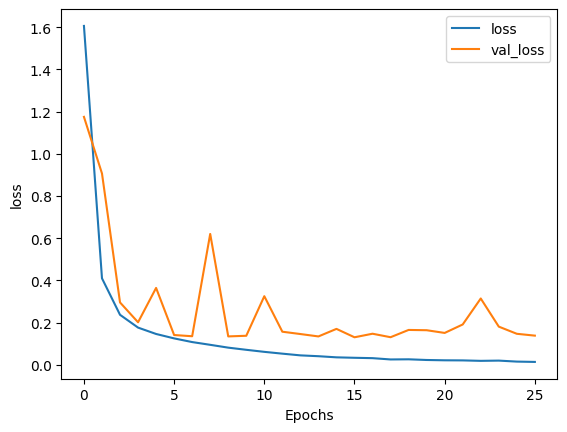

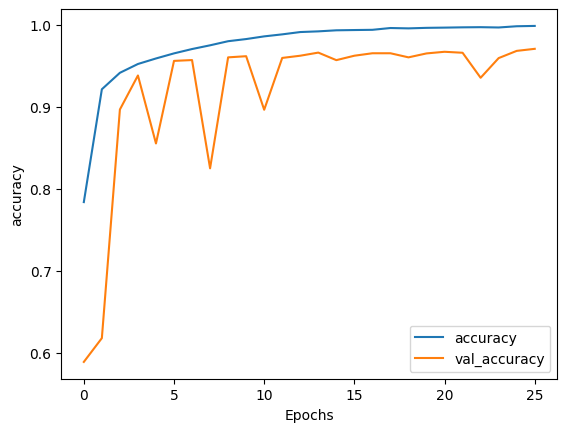

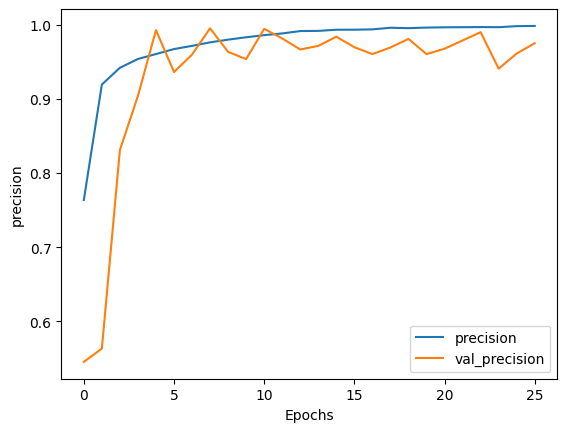

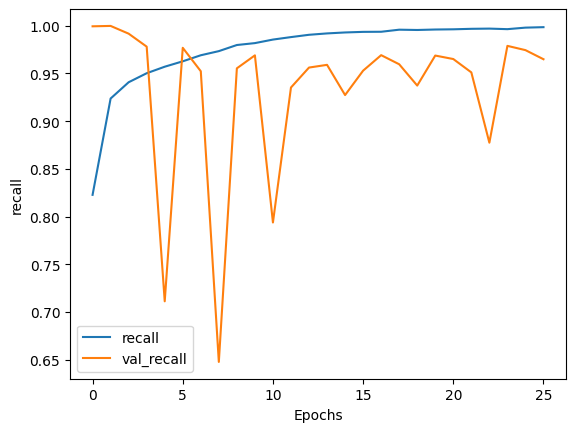

In [12]:
plotMetrics(VGG16_history, "loss")
plotMetrics(VGG16_history, "accuracy")
plotMetrics(VGG16_history, "precision")
plotMetrics(VGG16_history, "recall")

---
# MobileNet
---

In [14]:
MobileNet_base = tf.keras.applications.MobileNetV3Small(
    include_top = False,
    weights = 'imagenet',
    input_shape = (imgHeight, imgWidth, 3),
    pooling = 'max'
)

MobileNet_base.trainable = True

input = tf.keras.Input(shape = (imgHeight, imgWidth, 3))
conf = MobileNet_base(input, training = False)
conf = BatchNormalization(
    axis = -1,
    momentum = 0.99,
    epsilon = 0.001)(conf)
conf = Dense(
    256,
    kernel_regularizer = regularizers.l2(0.01),
    activity_regularizer = regularizers.l1(0.01),
    bias_regularizer = regularizers.l1(0.01),
    activation = "relu")(conf)
conf = Dropout(
    rate = .4,
    seed = 500)(conf)
conf = Dense(
    64,
    activation="relu")(conf)
output = Dense(1, activation = "sigmoid")(conf)

MobileNet_model = tf.keras.Model(input, output)

MobileNet_model.compile(optimizer = tf.keras.optimizers.Adamax(learning_rate = .001), loss = tf.keras.losses.BinaryCrossentropy(), metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

MobileNet_model.summary()

4334752/4334752 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 MobilenetV3small (Function  (None, 576)               939120    
 al)                                                             
                                                                 
 batch_normalization_1 (Bat  (None, 576)               2304      
 chNormalization)                                                
                                                                 
 dense_3 (Dense)             (None, 256)               147712    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                              

In [15]:
print("Starting trainging at", datetime.now())
MobileNet_history = MobileNet_model.fit(
    trainingSet,
    validation_data = validationSet,
    epochs = 100,
    verbose = 1,
    callbacks = [early_stopping]
)
print("Finished trainging at", datetime.now())
MobileNet_model.save("MobileNet-1-gen.keras")
print("Saved trained model")

Starting trainging at 2024-05-11 10:37:50.963568
Epoch 1/100
180/180 [==============================] - 48s 122ms/step - loss: 1.5745 - accuracy: 0.8341 - precision_1: 0.8542 - recall_1: 0.8064 - val_loss: 1.0080 - val_accuracy: 0.7466 - val_precision_1: 0.9930 - val_recall_1: 0.4891
Epoch 2/100
180/180 [==============================] - 20s 110ms/step - loss: 0.3746 - accuracy: 0.9215 - precision_1: 0.9217 - recall_1: 0.9215 - val_loss: 0.3283 - val_accuracy: 0.9026 - val_precision_1: 0.9645 - val_recall_1: 0.8330
Epoch 3/100
180/180 [==============================] - 20s 108ms/step - loss: 0.2411 - accuracy: 0.9342 - precision_1: 0.9340 - recall_1: 0.9347 - val_loss: 0.2159 - val_accuracy: 0.9345 - val_precision_1: 0.9260 - val_recall_1: 0.9424
Epoch 4/100
180/180 [==============================] - 20s 110ms/step - loss: 0.2014 - accuracy: 0.9404 - precision_1: 0.9398 - recall_1: 0.9413 - val_loss: 0.1942 - val_accuracy: 0.9378 - val_precision_1: 0.9504 - val_recall_1: 0.9219
Epoch 5

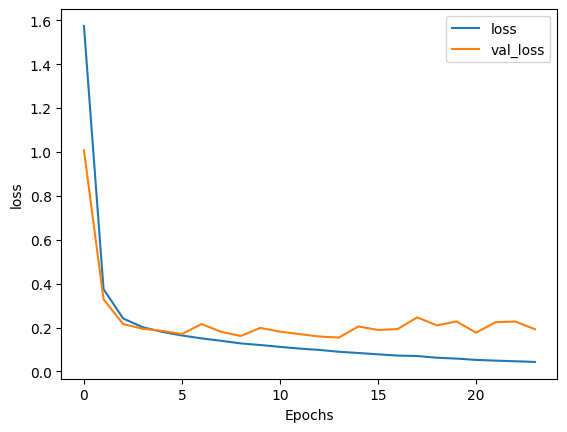

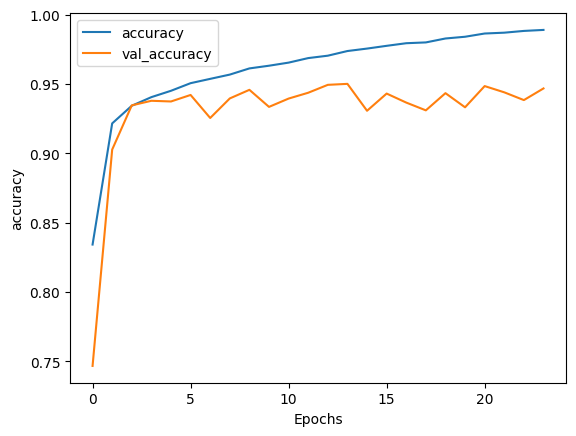

In [19]:
plotMetrics(MobileNet_history, "loss")
plotMetrics(MobileNet_history, "accuracy")
#plotMetrics(MobileNet_history, "precision_3")
#plotMetrics(MobileNet_history, "recall_3")

---
# Testing
---

In [8]:
loadedModel = tf.keras.saving.load_model("VGG16-1-gen.keras")

In [18]:
loadedModel = tf.keras.saving.load_model("MobileNet-1-gen.keras")

In [19]:
val_loss, val_accuracy, val_precision, val_recall = loadedModel.evaluate(testingSet)

print(f"Loss: {val_loss:.4f}")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")

40/40 [==============================] - 5s 40ms/step - loss: 0.1557 - accuracy: 0.9495 - precision_1: 0.9465 - recall_1: 0.9529
Loss: 0.1557
Accuracy: 0.9495
Precision: 0.9465
Recall: 0.9529


1/1 [==============================] - 0s 23ms/step


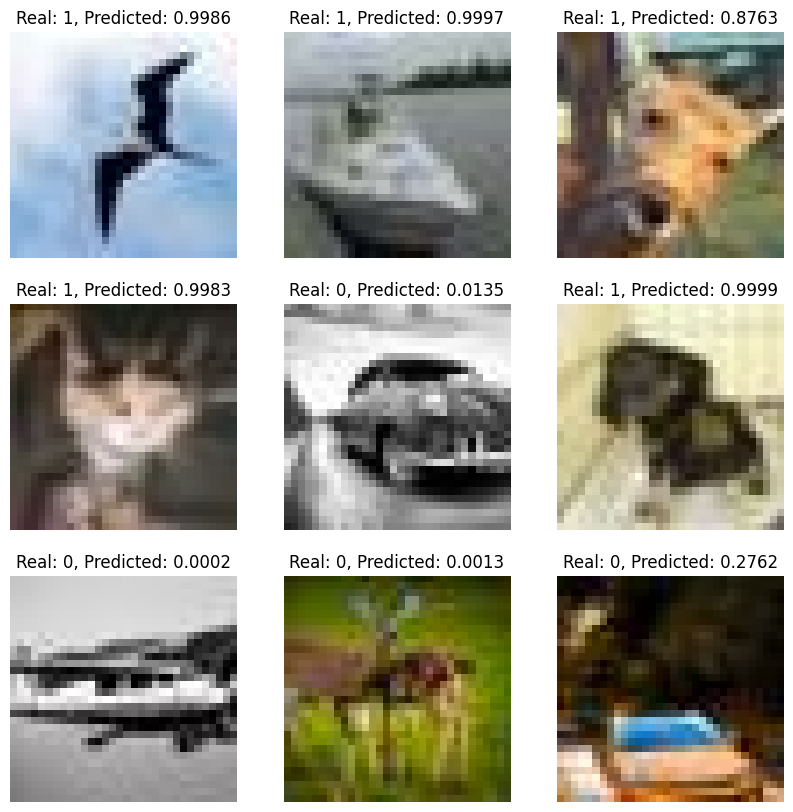

In [20]:
plt.figure(figsize=(10, 10))
for images, labels in trainingSet.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        result = loadedModel.predict(np.expand_dims(np.array(images[i]), axis = 0))
        plt.title(f"Real: {int(labels[i])}, Predicted: {result[0 ,0]:.4f}")
        plt.axis("off")


In [ ]:
uploaded = files.upload()

1/1 [==============================] - 1s 868ms/step


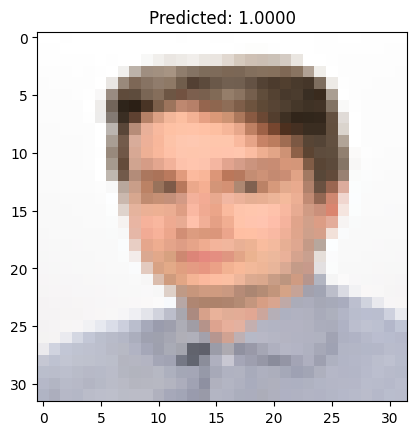

In [21]:
with pimg.open('cv.jpg') as img:
  res = img.resize((imgWidth, imgHeight))
  result = loadedModel.predict(np.expand_dims(np.array(res), axis = 0))
  plt.title(f"Predicted: {result[0 ,0]:.4f}")
  imgplot = plt.imshow(res)
  plt.show()